In [1]:
from gurobipy import *
from tqdm import tqdm
from scipy.stats import f_oneway
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Define MTZ Functions

In [2]:
def build_mtz_model(N, is_ip=True):
    model = Model("MTZ_TSP")
    model.Params.OutputFlag = 0
    
    # Variable type
    vtype = GRB.BINARY if is_ip else GRB.CONTINUOUS

    x = model.addVars(N, N, lb=0, ub=1, vtype=vtype, name="x")
    u = model.addVars(N, lb=0, ub=N-1, name="u")

    # Constraints
    model.addConstrs((quicksum(x[i, j] for j in range(N)) == 1 for i in range(N)))
    model.addConstrs((quicksum(x[i, j] for i in range(N)) == 1 for j in range(N)))
    model.addConstrs((x[i, i] == 0 for i in range(N)))
    model.addConstr(u[0] == 0)

    for i in range(1, N):
        for j in range(1, N):
            if i != j:
                model.addConstr(u[i] - u[j] + 1 <= (N-1)*(1 - x[i, j]))

    return model, x

In [3]:
# Solve MTZ model
def solve_mtz(template_model, x, distance_matrix, time_limit = None):

    N = distance_matrix.shape[0]
    model = template_model

    model.setObjective(quicksum(distance_matrix[i, j] * x[i, j] for i in range(N) for j in range(N)),GRB.MINIMIZE)

    # Set time limit 
    if time_limit:
        model.Params.TimeLimit = time_limit

    if model.ModelName == "MTZ_TSP":  
        model.Params.MIPFocus = 1

    model.optimize()

    if model.Status == GRB.OPTIMAL:
        return model.objVal, False  
    elif model.Status == GRB.TIME_LIMIT:
        if model.SolCount > 0:
            return model.objVal, True  
        else:
            return None, True  
    else:
        return None, False  

## Run Model

In [4]:
sizes = [15,18,20]    
structures = ["clustered", "grid", "hub_spoke", "random"]
instances = range(10)

base_path = "C:\\Users\\user\\Desktop\\5103_Project\\DBA5103_TSP_Data"    
results = []

# Show tqdm progress bar
total_runs = len(sizes) * len(structures) * len(instances)
pbar = tqdm(total=total_runs, desc="Solving TSP instances")

for n in sizes:
    lp_model, lp_x = build_mtz_model(n, is_ip=False)
    ip_model, ip_x = build_mtz_model(n, is_ip=True)

    for s in structures:
        for i in instances:
            filename = f"dist_n{n}_{s}_i{i}.csv"
            fullpath = os.path.join(base_path, filename)

            tqdm.write(f"Current file: {filename}")
            distance_matrix = pd.read_csv(fullpath, header=None).values

            # Solve LP 
            w, _ = solve_mtz(lp_model, lp_x, distance_matrix)

            # Solve IP with time limit 
            z, limited = solve_mtz(ip_model, ip_x, distance_matrix, time_limit=300)

            gap = (z - w)/z * 100 if z is not None else None

            results.append({
                "city_number": n,
                "structure": s,
                "instance": i,
                "z": z,
                "w": w,
                "gap": gap,
                "time_limited":limited})

            pbar.update(1)

pbar.close()

results_df = pd.DataFrame(results)

Solving TSP instances:   0%|          | 0/120 [00:00<?, ?it/s]

Set parameter Username
Set parameter LicenseID to value 2698692
Academic license - for non-commercial use only - expires 2026-08-22


Solving TSP instances:   0%|          | 0/120 [00:00<?, ?it/s]

Current file: dist_n15_clustered_i0.csv


Solving TSP instances:   1%|          | 1/120 [00:03<06:37,  3.34s/it]

Current file: dist_n15_clustered_i1.csv


Solving TSP instances:   2%|▏         | 2/120 [00:22<24:44, 12.58s/it]

Current file: dist_n15_clustered_i2.csv


Solving TSP instances:   2%|▎         | 3/120 [00:26<17:20,  8.90s/it]

Current file: dist_n15_clustered_i3.csv


Solving TSP instances:   3%|▎         | 4/120 [00:28<11:26,  5.92s/it]

Current file: dist_n15_clustered_i4.csv


Solving TSP instances:   4%|▍         | 5/120 [00:29<07:55,  4.14s/it]

Current file: dist_n15_clustered_i5.csv


Solving TSP instances:   5%|▌         | 6/120 [01:07<30:08, 15.86s/it]

Current file: dist_n15_clustered_i6.csv


Solving TSP instances:   6%|▌         | 7/120 [01:09<21:15, 11.29s/it]

Current file: dist_n15_clustered_i7.csv


Solving TSP instances:   7%|▋         | 8/120 [01:10<15:00,  8.04s/it]

Current file: dist_n15_clustered_i8.csv


Solving TSP instances:   8%|▊         | 9/120 [01:12<11:08,  6.03s/it]

Current file: dist_n15_clustered_i9.csv


Solving TSP instances:  12%|█▏        | 14/120 [01:18<04:41,  2.65s/it]

Current file: dist_n15_grid_i0.csv
Current file: dist_n15_grid_i1.csv
Current file: dist_n15_grid_i2.csv
Current file: dist_n15_grid_i3.csv
Current file: dist_n15_grid_i4.csv


Solving TSP instances:  17%|█▋        | 20/120 [01:19<01:41,  1.01s/it]

Current file: dist_n15_grid_i5.csv
Current file: dist_n15_grid_i6.csv
Current file: dist_n15_grid_i7.csv
Current file: dist_n15_grid_i8.csv
Current file: dist_n15_grid_i9.csv
Current file: dist_n15_hub_spoke_i0.csv


Solving TSP instances:  18%|█▊        | 21/120 [01:19<01:06,  1.50it/s]

Current file: dist_n15_hub_spoke_i1.csv


Solving TSP instances:  18%|█▊        | 22/120 [01:19<01:05,  1.50it/s]

Current file: dist_n15_hub_spoke_i2.csv


Solving TSP instances:  20%|██        | 24/120 [01:20<00:53,  1.79it/s]

Current file: dist_n15_hub_spoke_i3.csv
Current file: dist_n15_hub_spoke_i4.csv


Solving TSP instances:  21%|██        | 25/120 [01:20<00:43,  2.19it/s]

Current file: dist_n15_hub_spoke_i5.csv


Solving TSP instances:  22%|██▎       | 27/120 [01:20<00:34,  2.67it/s]

Current file: dist_n15_hub_spoke_i6.csv
Current file: dist_n15_hub_spoke_i7.csv


Solving TSP instances:  23%|██▎       | 28/120 [01:21<00:32,  2.81it/s]

Current file: dist_n15_hub_spoke_i8.csv


Solving TSP instances:  25%|██▌       | 30/120 [01:21<00:27,  3.24it/s]

Current file: dist_n15_hub_spoke_i9.csv


Solving TSP instances:  25%|██▌       | 30/120 [01:21<00:27,  3.24it/s]

Current file: dist_n15_random_i0.csv


Solving TSP instances:  27%|██▋       | 32/120 [01:21<00:22,  3.93it/s]

Current file: dist_n15_random_i1.csv
Current file: dist_n15_random_i2.csv


Solving TSP instances:  30%|███       | 36/120 [01:22<00:10,  7.79it/s]

Current file: dist_n15_random_i3.csv
Current file: dist_n15_random_i4.csv
Current file: dist_n15_random_i5.csv
Current file: dist_n15_random_i6.csv


Solving TSP instances:  31%|███       | 37/120 [01:22<00:10,  7.79it/s]

Current file: dist_n15_random_i7.csv


Solving TSP instances:  33%|███▎      | 40/120 [01:22<00:11,  7.19it/s]

Current file: dist_n15_random_i8.csv
Current file: dist_n15_random_i9.csv
Current file: dist_n18_clustered_i0.csv


Solving TSP instances:  34%|███▍      | 41/120 [01:28<01:11,  1.10it/s]

Current file: dist_n18_clustered_i1.csv


Solving TSP instances:  35%|███▌      | 42/120 [02:38<16:34, 12.75s/it]

Current file: dist_n18_clustered_i2.csv


Solving TSP instances:  36%|███▌      | 43/120 [07:38<1:28:36, 69.05s/it]

Current file: dist_n18_clustered_i3.csv


Solving TSP instances:  37%|███▋      | 44/120 [08:32<1:23:24, 65.84s/it]

Current file: dist_n18_clustered_i4.csv


Solving TSP instances:  38%|███▊      | 45/120 [13:33<2:32:00, 121.61s/it]

Current file: dist_n18_clustered_i5.csv


Solving TSP instances:  38%|███▊      | 46/120 [15:11<2:22:45, 115.75s/it]

Current file: dist_n18_clustered_i6.csv


Solving TSP instances:  39%|███▉      | 47/120 [17:28<2:27:31, 121.26s/it]

Current file: dist_n18_clustered_i7.csv


Solving TSP instances:  40%|████      | 48/120 [17:39<1:49:22, 91.15s/it] 

Current file: dist_n18_clustered_i8.csv


Solving TSP instances:  41%|████      | 49/120 [22:39<2:57:38, 150.12s/it]

Current file: dist_n18_clustered_i9.csv


Solving TSP instances:  42%|████▏     | 50/120 [27:40<3:45:35, 193.37s/it]

Current file: dist_n18_grid_i0.csv


Solving TSP instances:  46%|████▌     | 55/120 [27:42<1:06:21, 61.26s/it] 

Current file: dist_n18_grid_i1.csv
Current file: dist_n18_grid_i2.csv
Current file: dist_n18_grid_i3.csv
Current file: dist_n18_grid_i4.csv
Current file: dist_n18_grid_i5.csv


Solving TSP instances:  50%|█████     | 60/120 [27:42<34:10, 34.18s/it]  

Current file: dist_n18_grid_i6.csv
Current file: dist_n18_grid_i7.csv
Current file: dist_n18_grid_i8.csv
Current file: dist_n18_grid_i9.csv
Current file: dist_n18_hub_spoke_i0.csv


Solving TSP instances:  51%|█████     | 61/120 [27:43<18:20, 18.65s/it]

Current file: dist_n18_hub_spoke_i1.csv


Solving TSP instances:  52%|█████▏    | 62/120 [27:44<18:01, 18.65s/it]

Current file: dist_n18_hub_spoke_i2.csv


Solving TSP instances:  52%|█████▎    | 63/120 [27:44<13:30, 14.21s/it]

Current file: dist_n18_hub_spoke_i3.csv


Solving TSP instances:  53%|█████▎    | 64/120 [27:45<11:21, 12.16s/it]

Current file: dist_n18_hub_spoke_i4.csv


Solving TSP instances:  54%|█████▍    | 65/120 [27:45<09:16, 10.11s/it]

Current file: dist_n18_hub_spoke_i5.csv


Solving TSP instances:  55%|█████▌    | 66/120 [27:46<07:21,  8.18s/it]

Current file: dist_n18_hub_spoke_i6.csv


Solving TSP instances:  56%|█████▌    | 67/120 [27:46<05:42,  6.46s/it]

Current file: dist_n18_hub_spoke_i7.csv


Solving TSP instances:  57%|█████▋    | 68/120 [27:47<04:23,  5.06s/it]

Current file: dist_n18_hub_spoke_i8.csv


Solving TSP instances:  57%|█████▊    | 69/120 [27:47<03:18,  3.90s/it]

Current file: dist_n18_hub_spoke_i9.csv


Solving TSP instances:  58%|█████▊    | 70/120 [27:48<02:29,  2.99s/it]

Current file: dist_n18_random_i0.csv


Solving TSP instances:  61%|██████    | 73/120 [27:48<00:59,  1.27s/it]

Current file: dist_n18_random_i1.csv
Current file: dist_n18_random_i2.csv
Current file: dist_n18_random_i3.csv


Solving TSP instances:  62%|██████▏   | 74/120 [27:49<00:46,  1.01s/it]

Current file: dist_n18_random_i4.csv


Solving TSP instances:  63%|██████▎   | 76/120 [27:49<00:29,  1.48it/s]

Current file: dist_n18_random_i5.csv
Current file: dist_n18_random_i6.csv


Solving TSP instances:  65%|██████▌   | 78/120 [27:49<00:18,  2.27it/s]

Current file: dist_n18_random_i7.csv
Current file: dist_n18_random_i8.csv


Solving TSP instances:  66%|██████▌   | 79/120 [27:50<00:18,  2.27it/s]

Current file: dist_n18_random_i9.csv


Solving TSP instances:  67%|██████▋   | 80/120 [27:50<00:11,  3.34it/s]

Current file: dist_n20_clustered_i0.csv


Solving TSP instances:  68%|██████▊   | 81/120 [32:50<47:20, 72.85s/it]

Current file: dist_n20_clustered_i1.csv


Solving TSP instances:  68%|██████▊   | 82/120 [37:50<1:23:10, 131.33s/it]

Current file: dist_n20_clustered_i2.csv


Solving TSP instances:  69%|██████▉   | 83/120 [42:51<1:49:04, 176.88s/it]

Current file: dist_n20_clustered_i3.csv


Solving TSP instances:  70%|███████   | 84/120 [47:53<2:06:51, 211.42s/it]

Current file: dist_n20_clustered_i4.csv


Solving TSP instances:  71%|███████   | 85/120 [52:54<2:18:07, 236.78s/it]

Current file: dist_n20_clustered_i5.csv


Solving TSP instances:  72%|███████▏  | 86/120 [57:55<2:24:42, 255.36s/it]

Current file: dist_n20_clustered_i6.csv


Solving TSP instances:  72%|███████▎  | 87/120 [1:02:56<2:27:50, 268.81s/it]

Current file: dist_n20_clustered_i7.csv


Solving TSP instances:  73%|███████▎  | 88/120 [1:07:57<2:28:24, 278.28s/it]

Current file: dist_n20_clustered_i8.csv


Solving TSP instances:  74%|███████▍  | 89/120 [1:08:24<1:45:22, 203.96s/it]

Current file: dist_n20_clustered_i9.csv


Solving TSP instances:  75%|███████▌  | 90/120 [1:13:24<1:56:15, 232.50s/it]

Current file: dist_n20_grid_i0.csv


Solving TSP instances:  79%|███████▉  | 95/120 [1:13:26<29:56, 71.86s/it]   

Current file: dist_n20_grid_i1.csv
Current file: dist_n20_grid_i2.csv
Current file: dist_n20_grid_i3.csv
Current file: dist_n20_grid_i4.csv
Current file: dist_n20_grid_i5.csv


Solving TSP instances:  83%|████████▎ | 100/120 [1:13:26<11:35, 34.76s/it]

Current file: dist_n20_grid_i6.csv
Current file: dist_n20_grid_i7.csv
Current file: dist_n20_grid_i8.csv
Current file: dist_n20_grid_i9.csv
Current file: dist_n20_hub_spoke_i0.csv


Solving TSP instances:  84%|████████▍ | 101/120 [1:13:31<07:16, 22.99s/it]

Current file: dist_n20_hub_spoke_i1.csv


Solving TSP instances:  85%|████████▌ | 102/120 [1:13:36<06:53, 22.99s/it]

Current file: dist_n20_hub_spoke_i2.csv


Solving TSP instances:  86%|████████▌ | 103/120 [1:13:40<05:11, 18.32s/it]

Current file: dist_n20_hub_spoke_i3.csv


Solving TSP instances:  87%|████████▋ | 104/120 [1:13:44<04:18, 16.14s/it]

Current file: dist_n20_hub_spoke_i4.csv


Solving TSP instances:  88%|████████▊ | 105/120 [1:13:48<03:28, 13.92s/it]

Current file: dist_n20_hub_spoke_i5.csv


Solving TSP instances:  88%|████████▊ | 106/120 [1:13:56<02:59, 12.82s/it]

Current file: dist_n20_hub_spoke_i6.csv


Solving TSP instances:  89%|████████▉ | 107/120 [1:14:00<02:19, 10.73s/it]

Current file: dist_n20_hub_spoke_i7.csv


Solving TSP instances:  90%|█████████ | 108/120 [1:14:02<01:43,  8.67s/it]

Current file: dist_n20_hub_spoke_i8.csv


Solving TSP instances:  91%|█████████ | 109/120 [1:14:09<01:29,  8.14s/it]

Current file: dist_n20_hub_spoke_i9.csv


Solving TSP instances:  92%|█████████▎| 111/120 [1:14:18<01:15,  8.34s/it]

Current file: dist_n20_random_i0.csv
Current file: dist_n20_random_i1.csv


Solving TSP instances:  94%|█████████▍| 113/120 [1:14:18<00:33,  4.81s/it]

Current file: dist_n20_random_i2.csv
Current file: dist_n20_random_i3.csv


Solving TSP instances:  95%|█████████▌| 114/120 [1:14:19<00:18,  3.02s/it]

Current file: dist_n20_random_i4.csv


Solving TSP instances:  96%|█████████▌| 115/120 [1:14:19<00:12,  2.50s/it]

Current file: dist_n20_random_i5.csv


Solving TSP instances:  97%|█████████▋| 116/120 [1:14:20<00:08,  2.06s/it]

Current file: dist_n20_random_i6.csv


Solving TSP instances:  98%|█████████▊| 117/120 [1:14:20<00:05,  1.69s/it]

Current file: dist_n20_random_i7.csv


Solving TSP instances: 100%|██████████| 120/120 [1:14:22<00:00, 37.18s/it]

Current file: dist_n20_random_i8.csv
Current file: dist_n20_random_i9.csv


In [10]:
print(results_df)

     city_number  structure  instance           z           w        gap  \
0             15  clustered         0  254.298224   43.033671  83.077479   
1             15  clustered         1  218.607414   46.567780  78.697987   
2             15  clustered         2  173.162125   46.337617  73.240328   
3             15  clustered         3  186.602938   25.057601  86.571701   
4             15  clustered         4  208.249334   51.300423  75.365865   
..           ...        ...       ...         ...         ...        ...   
115           20     random         5  436.889058  376.371572  13.851912   
116           20     random         6  367.101388  270.207454  26.394325   
117           20     random         7  434.052319  352.039409  18.894706   
118           20     random         8  342.396006  265.160050  22.557493   
119           20     random         9  393.598989  366.790571   6.811099   

     time_limited  
0           False  
1           False  
2           False  
3      

In [11]:
# Output summary statistics 
summary = results_df.groupby(["city_number","structure"]).agg(
    avg_gap = ("gap", "mean"),
    std_gap = ("gap", "std")).reset_index()

print(summary)

    city_number  structure    avg_gap    std_gap
0            15  clustered  77.834998   4.620557
1            15       grid   0.049601   0.023458
2            15  hub_spoke  15.905011   1.373818
3            15     random  19.635934   5.772326
4            18  clustered  74.306227  11.011953
5            18       grid   0.054317   0.027920
6            18  hub_spoke  14.969137   1.775490
7            18     random  19.649575   6.340305
8            20  clustered  73.735897   5.729189
9            20       grid   0.040804   0.019370
10           20  hub_spoke  15.938431   1.203959
11           20     random  18.412252   7.979225


## Visualization: Integrality gap v.s n_cities

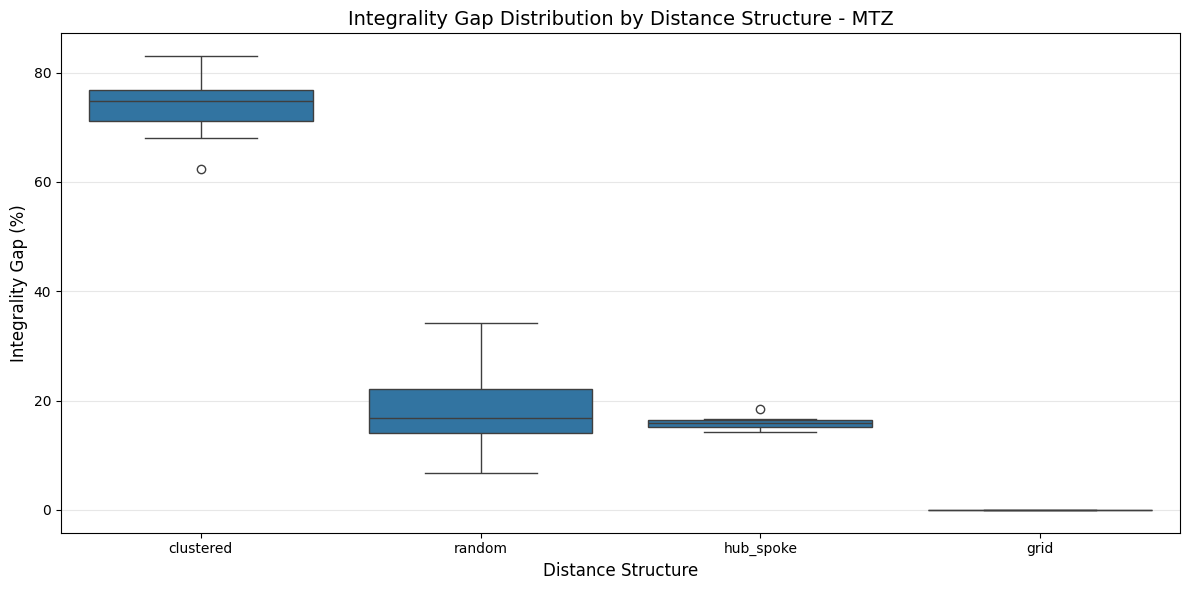

In [12]:
plt.figure(figsize=(12, 6))

data_n20 = results_df[results_df['city_number'] == 20]
structure_order = (data_n20.groupby('structure')['gap'].mean().sort_values(ascending=False).index)

sns.boxplot(data=data_n20, x='structure', y='gap', order=structure_order)

plt.xlabel('Distance Structure', fontsize=12)
plt.ylabel('Integrality Gap (%)', fontsize=12)
plt.title('Integrality Gap Distribution by Distance Structure - MTZ', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Visualization: Integrality Gap v.s Structure

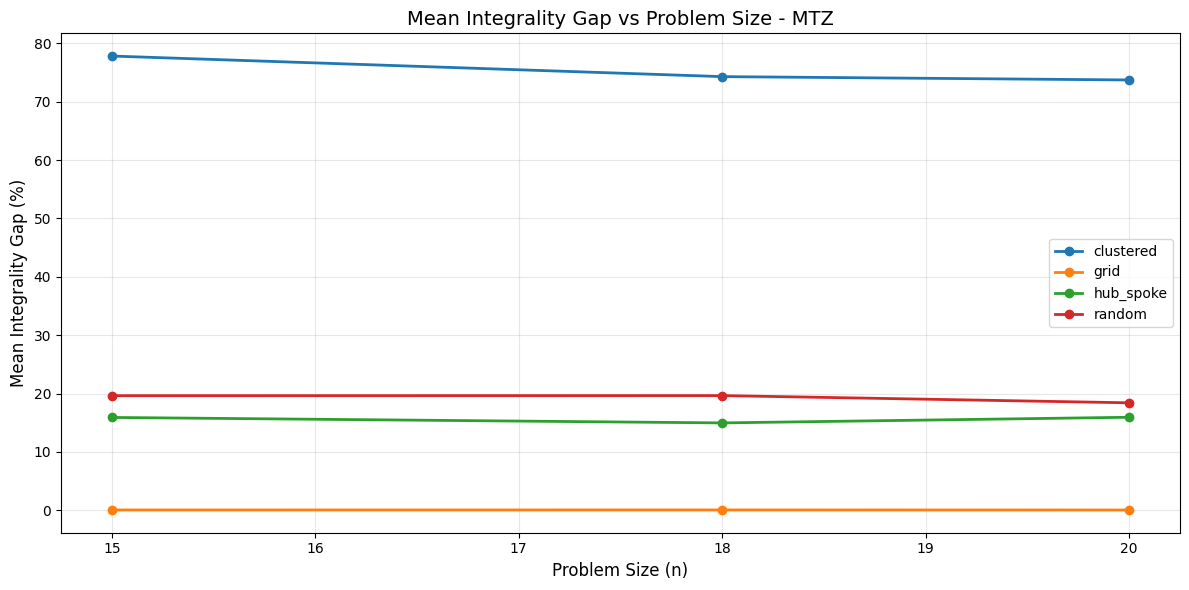

In [13]:
plt.figure(figsize=(12, 6))

gap_by_size = results_df.groupby(['city_number', 'structure'])['gap'].mean().reset_index()

for structure in sorted(results_df['structure'].unique()):
    data = gap_by_size[gap_by_size['structure'] == structure]
    plt.plot(data['city_number'], data['gap'], marker='o', label=structure, linewidth=2)
plt.xlabel('Problem Size (n)', fontsize=12)
plt.ylabel('Mean Integrality Gap (%)', fontsize=12)
plt.title('Mean Integrality Gap vs Problem Size - MTZ', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Visualization: IP and LP Objectives

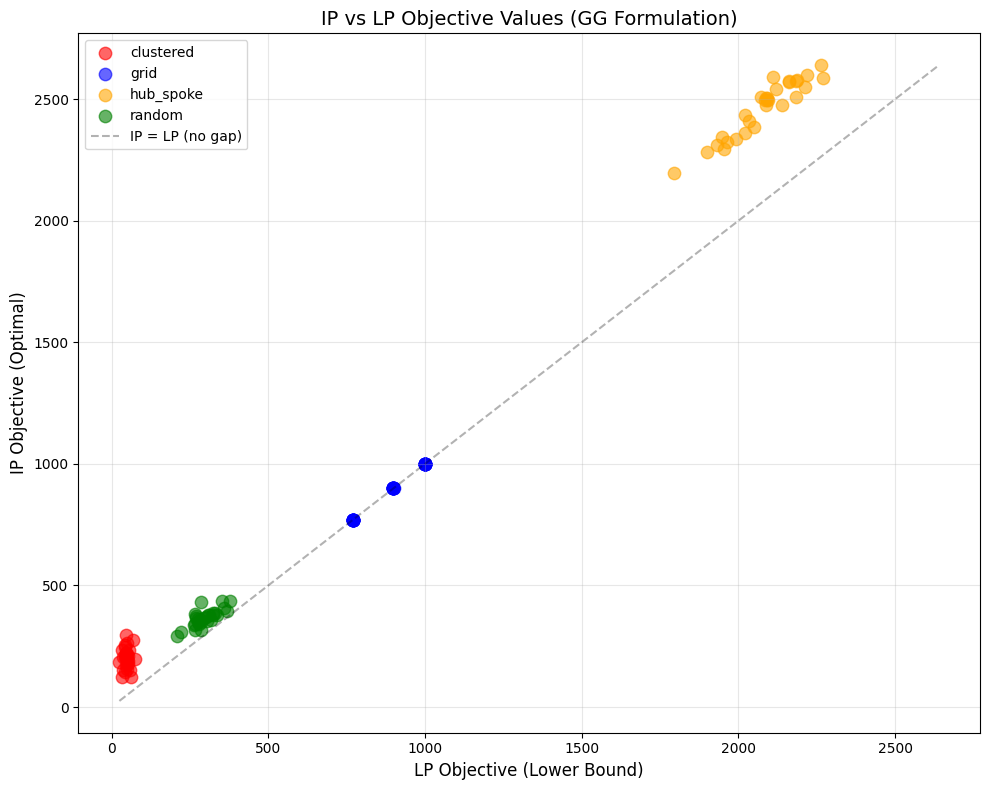

In [15]:
plt.figure(figsize=(10, 8))

colors = {'grid': 'blue', 'random': 'green', 'clustered': 'red', 'hub_spoke': 'orange'}

for structure in sorted(results_df['structure'].unique()):
    df_struct = results_df[results_df['structure'] == structure]
    plt.scatter(df_struct['w'], df_struct['z'],
               label=structure, alpha=0.6, s=80, color=colors.get(structure, 'gray'))

# Add diagonal line (IP = LP would be on this line)
min_val = min(results_df['w'].min(), results_df['z'].min())
max_val = max(results_df['w'].max(), results_df['z'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='IP = LP (no gap)')

plt.xlabel('LP Objective (Lower Bound)', fontsize=12)
plt.ylabel('IP Objective (Optimal)', fontsize=12)
plt.title('IP vs LP Objective Values (GG Formulation)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Statistical Analysis

##### Question: Does the cost structure significantly affect integrality gaps within the MTZ

In [9]:
clustered = results_df[results_df["structure"] == "clustered"]["gap"]
grid = results_df[results_df["structure"] == "grid"]["gap"]
hub_spoke = results_df[results_df["structure"] == "hub_spoke"]["gap"]
random = results_df[results_df["structure"] == "random"]["gap"]

# one-way ANOVA
f_stat, p_value = f_oneway(clustered, grid, hub_spoke, random)

print("F-statistic:", f_stat)
print("p-value:", p_value)

F-statistic: 1261.2815332794107
p-value: 2.4453251784191926e-88


##### since p < 0.05, we reject H0. Conclusion: structures have significantly different mean gaps